<a href="https://colab.research.google.com/github/DesiPilla/twitter-sentiment-analysis/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

Group members:
 * Olivia Mwangi
 * Desiderio Pilla
 * Akshaya Ramesh

# Problem Statement

On Twitter, users all over the world can express their opinion on any topic in a matter of seconds. By searching keywords or hashtags, anyone can scroll through a feed of content relating to any interest they like. The rise of social media has seen an uptick in polarizing content on the web, as it has become extraordinarily easy to share one's views. 

An important field of data science is sentiment analysis, which uses natural language processing to extract certain emotions of feelings from text. The main goal of this project is to build and train a model that can detect the sentiment of a tweet. For simplicity, this model limit its scope to label all tweets into one of these three categories:
 * negative
 * neutral
 * positive

Though there are many more specific sentiments that would need to be learned in order to obtain a clearer picture of a tweet's intentions, we will limit our model to learning these three classifications. However, a perfect model is nearly impossible to create. The reason is because sentiment is highly subjective. Anywhere from 10% - 30% of tweets would cause a debate amongst humans as to which category they fall into. To illustrate this, consider the following two tweets:

> I love the world!
>
> I hate the world.

These two tweets clearly fall into the positive and negative, respectively, sentiment categories. However, consider this tweet:

> I am indifferent about the world.

This tweet lies somewhere in between the previous two. Yet, rather than labeling it as "neutral", one could argue that this in fact illicits a negative sentiment, as people who don't view the world positively must view it negatively. Another non-trivial tweet is:

> The S&P 500 was down 300 points on Thursday.

This would come as bad news for investors, but happy news for short-sellers. But broadly, this tweet doesn't seem to have any emotion, but rather only delivers a fact. Lastly, consider one more tweet:

> I love candy, but it has too much sugar in it!

This person begins by saying something positive, but then ends it negatively. Overall, it is unclear whether this is a net-positive or net-negative tweet. It is also not as bland as the third example tweet; this sentence exhibits both positive and negative sentiments in one. The point of these examples is to show that sentiment analysis is not an exact science. Furthermore, not all sentiments are as easy to distinguish. A "neutral" label is much more subjective and poorly-defined that a "positive" or "negative" label.

In this project, we aim to create a machine learning model that is able to accurately classify the sentiment of a tweet, with the expectation that the "true" accuracy of the model will be limited by the subjective nature of this application. Once a model has been created, trained, and validated, we intend to use it on real-time and historical tweets to collect aggregated sentiment scores for varying topics and subjects to create time series charts.

# Import packages

In [3]:
# Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install tweepy

# Import other relevant packages
import tweepy
import re
import math
import string
import pickle
from urllib.request import urlopen
from string import punctuation
from joblib import dump, load
from skimage import io
from wordcloud import WordCloud, STOPWORDS

# Import and download NLP functions
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Import sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Import estimators
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Import streamlined methodology methods
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Utility functions

In [0]:
def print_balance(df, col='senti'):
    if type(df) == pd.DataFrame:
        counts = df[col].value_counts(normalize=True)
    else:
        labels, counts = np.unique(y_test, return_counts=True)
        counts = dict(zip(labels, counts / len(y_test)))

    print('This dataset contains {0} negative tweets ({1:.1%})'.format(int(counts[0]*len(df)), counts[0]))
    print('This dataset contains {0} neutral tweets ({1:.1%})'.format(int(counts[2]*len(df)), counts[2]))
    print('This dataset contains {0} positive tweets ({1:.1%})'.format(int(counts[4]*len(df)), counts[4]))
    return counts

def balance(df, col='senti', weights=(1, 1, 1)):
    # Get the number of observations with each classification
    counts = df[col].value_counts(normalize=True)

    # Get the smallest number of observations for a sentiment label
    minNum = int(counts.min() * len(df))

    # Split the observations by sentiment and keep the same number of observations for each
    df_neg = df[df.senti == 0].iloc[:int(minNum*weights[0]), :]
    df_neu = df[df.senti == 2].iloc[:int(minNum*weights[1]), :]
    df_pos = df[df.senti == 4].iloc[:int(minNum*weights[2]), :]

    # Combine observations back into one dataframe 
    df_bal = pd.concat([df_neg, df_neu, df_pos])
    return df_bal

def clean_sentiment(s):
    '''
    This function cleans the sentiment label for tweets in the Sanders Analytics dataset.
    
    Inputs: string (sentiment label : {'negative', 'neutral', 'positive'})
    Outputs: integer (sentiment label : {0, 2, 4})
    '''
    if s == 'positive':
        return 4
    elif s == 'negative':
        return 0
    else:
        return 2

def preprocessTweets(text):
    text = str(text)
    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    return text


class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=SVC()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

# Get Training Data

For our training data, we will use two datasets.

The first dataset we will use comes from GitHub user [TharinduMunasinge](https://github.com/TharinduMunasinge/Twitter-Sentiment-Analysis/tree/master/DataSet). This dataset contains 997 tweets that have a pre-labeled sentiment:
 * 0 = negative
 * 2 = neutral
 * 4 = positive

In [0]:
data1 = pd.read_csv('https://github.com/TharinduMunasinge/Twitter-Sentiment-Analysis/raw/master/DataSet/FinalizedFull.csv').rename(columns={'tweet':'text'})
data1.head()

,text,senti
0,@united UA5396 can wait for me. I'm on the gro...,0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0
2,"@united Oh, we are sure it's not planned, but ...",0
3,Tom Shanahan's latest column on SDSU and its N...,2
4,Found the self driving car!! /IWo3QSvdu2,2


,text,senti
0,@united UA5396 can wait for me. I'm on the gro...,0
1,I hate Time Warner! Soooo wish I had Vios. Can...,0
2,"@united Oh, we are sure it's not planned, but ...",0
3,Tom Shanahan's latest column on SDSU and its N...,2
4,Found the self driving car!! /IWo3QSvdu2,2


In [0]:
# Check the balance of the dataset
counts1 = print_balance(data1)

This dataset contains 377 negative tweets (37.8%)
This dataset contains 239 neutral tweets (24.0%)
This dataset contains 381 positive tweets (38.2%)
This dataset contains 377 negative tweets (37.8%)
This dataset contains 239 neutral tweets (24.0%)
This dataset contains 381 positive tweets (38.2%)


As we can see, this dataset is not balanced. More tweets are labeled positive or negative than neutral. While this may be representative of all tweets, we may need to consider this so as to not bias our model. However, this dataset contains relatively few observations, so we will combine it with another dataset of labeled tweets as well.

The [second dataset](https://github.com/zfz/twitter_corpus) we will use in our training set comes from the twitter sentiment corpus created by Sanders Analytics. This dataset consists of 3424 relevant hand-classified tweets. Irrelevant observations in this dataset include Spanish content. For this project, we will restrict our model to only classify English tweets.

In [0]:
# Read in the dataset
data2 = pd.read_csv('https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv')[['Sentiment', 'TweetText']].rename(columns={'Sentiment':'senti', 'TweetText':'text'})

# Drop all spanish observations
data2 = data2[data2.senti != 'irrelevant']

# Clean the sentiment labels
data2['senti'] = data2['senti'].apply(clean_sentiment)

data2.head()

,senti,text
0,4,Now all @Apple has to do is get swype on the i...
1,4,@Apple will be adding more carrier support to ...
2,4,Hilarious @youtube video - guy does a duet wit...
3,4,@RIM you made it too easy for me to switch to ...
4,4,I just realized that the reason I got into twi...


,senti,text
0,4,Now all @Apple has to do is get swype on the i...
1,4,@Apple will be adding more carrier support to ...
2,4,Hilarious @youtube video - guy does a duet wit...
3,4,@RIM you made it too easy for me to switch to ...
4,4,I just realized that the reason I got into twi...


In [0]:
# Check the balance of the dataset
counts2 = print_balance(data2)

This dataset contains 572 negative tweets (16.7%)
This dataset contains 2333 neutral tweets (68.1%)
This dataset contains 519 positive tweets (15.2%)
This dataset contains 572 negative tweets (16.7%)
This dataset contains 2333 neutral tweets (68.1%)
This dataset contains 519 positive tweets (15.2%)


Unlike the first dataset, this corpus contains significantly more neutral tweets than it does positive/negative tweets. In any case, we will combine these two datasets to create a larger training set to work with.

**[INCLUDE STATEMENT EXPLAINING WHAT PREPROCESSING DOES**

In [0]:
# Concatenate both training sets and preprocess tweets
train = pd.concat([data1, data2])
train['text'] = train['text'].apply(preprocessTweets)

# Check the balance of the dataset
train_counts = print_balance(train)

This dataset contains 949 negative tweets (21.5%)
This dataset contains 2572 neutral tweets (58.2%)
This dataset contains 900 positive tweets (20.4%)
This dataset contains 949 negative tweets (21.5%)
This dataset contains 2572 neutral tweets (58.2%)
This dataset contains 900 positive tweets (20.4%)


In our comined training set, the number of neutral tweets is much larger than either of the other sentiments. Because neutral tweets are much harder to learn, it makes sense that we have a higher representation of these examples when training our model. For example, [this tweet](https://twitter.com/jtalmarode/status/1252743931311333377?s=20)


> That is awesome!  I love this!

is very easy and trivial to classify as positive. Likewise, [this tweet](https://twitter.com/Teelaniece/status/1252744624403333120)

> I hate people like wtf

can be classified as negative without much difficult as well. However, [this tweet](https://twitter.com/Kieronbeckett/status/1252742514160926722)

> Mr Lee, it is because I vape that I now can exercise more. Here is my take on forgetting bad memories, I have done it all my life ...its called a new day.

is much harder to decipher. It appears the person is in an argument and trying to keep his temper while also pushing an uplifting tone. Is it positive? Not really. Is it negative? Also no. Is it neutral? I guess? It is much more difficult to discern neutral tweets. With this in mind, we will keep our training set unbalanced in favor of having more neutral tweets to train our model.



In [0]:
# Create an adjusted dataset where there are twice as many neutral tweets as positive or negative tweets
train_adj = balance(train, weights=(1, 1.5, 1))

# Check the adjusted of the dataset
train_counts = print_balance(train_adj)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_adj.text.values, train_adj.senti.values, random_state=637)

This dataset contains 900 negative tweets (28.6%)
This dataset contains 1350 neutral tweets (42.9%)
This dataset contains 900 positive tweets (28.6%)
This dataset contains 900 negative tweets (28.6%)
This dataset contains 1350 neutral tweets (42.9%)
This dataset contains 900 positive tweets (28.6%)


In [0]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(train.text.values, train.senti.values, random_state=637)

It may be useful later on to see how our model performs on a balanced dataset versus an unbalanced (and perhaps more representative) dataset. 

In [0]:
# Split the test set into two equal parts
X_test_bal, X_test_full, y_test_bal, y_test_full = train_test_split(X_test, y_test, test_size=0.5, random_state=637)

# See composition of unbalanced test set
print('\033[1mComposition of unbalanced test set:\033[0m')
print_balance(y_test_full)

# Create the balanced dataframe
test_bal = pd.DataFrame({'text':X_test_bal, 'senti':y_test_bal})
test_bal = balance(test_bal)
print('\n\033[1mComposition of balanced test set:\033[0m')
print_balance(test_bal)

X_test_bal = test_bal.text.values
y_test_bal = test_bal.senti.values

Composition of unbalanced test set:
This dataset contains 111 negative tweets (20.2%)
This dataset contains 327 neutral tweets (59.1%)
This dataset contains 114 positive tweets (20.7%)

Composition of balanced test set:
This dataset contains 114 negative tweets (33.3%)
This dataset contains 114 neutral tweets (33.3%)
This dataset contains 114 positive tweets (33.3%)
Composition of unbalanced test set:
This dataset contains 111 negative tweets (20.2%)
This dataset contains 327 neutral tweets (59.1%)
This dataset contains 114 positive tweets (20.7%)

Composition of balanced test set:
This dataset contains 114 negative tweets (33.3%)
This dataset contains 114 neutral tweets (33.3%)
This dataset contains 114 positive tweets (33.3%)


# Overall Methodology

First, we will use `CountVectorizer` to create a dictionary where the keys are every word in the training set and the values are the frequencies of each word.
```
bow = CountVectorizer(lowercase=True, 
                      strip_accents='ascii',
                      stop_words='english')
bow.fit(X)
```
Next, we will convert the tweet text data (which is a 1D array) to an $n*w$ matrix, where *n* is the number of tweets in the training data and *w* is the number of words in the vocabulary dictionary. Each value in the matrix represents the number of times a given word appears in a given tweet. This will result in a very sparse dataset.
```
bow_matrix = bow.transform(X)
```
After this, we will use `TfidfTransformer` to calculate the term-frequency times inverse document-frequency (tf-idf) value for each word in the training set. 
 * term-frequency is the number of times the word appears in a tweet
 * inverse document-frequency is the number of texts that contain the word

Hence, a word's tf-idf score increases proportionally to the number of times it appears in the text, and is offset by the total number of tweets that contain the word. This is used to determine the importance of a word in a given tweet. The more times the word appears in the tweet, the more important it must be to the sentiment of the tweet. However, if many tweets contain this word, it must not be as important in differentiating between sentiments.

The `fit()` method will learn the idf vector, which is the total number of tweets that contain each word. The `transform()` method will compute the tf vector and calculate the tf-idf matrix.
```
tfidf_transformer = TfidfTransformer()
tfdif.fit(bow_matrix)
messages_tfidf = tfidf_transformer.transform(bow_matrix)
```
Finally, we will use `MultinomialNB` to train the tf-idf vectors with a Naive-Bayes classifier. This will be the final model that is used to classify tweet sentiment.
```
model = MultinomialNB().fit(messages_tfidf)
```
---
</br>

## Streamlined Methodology

Notice in the previous methodology that the three estimators (`CountVectorizer`, `TfidfTransformer`, and `MultinomialNB`) are used almost identically. Each estimator is instantiated, fit with the most recent estimator, and then transformed (except for the final estimator, which need only be trained). This process can be streamlined by using the `Pipeline` object. This object will conduct a series of fits and transforms. The code below will replicate the desired executions:
 * fit a `CountVectorizer` to the training set and transform it
 * fit a `TfidfTransformer` to the previous estimator and transform it
 * fit a `MultinomialNB` to the previous estimator

```
pipeline = Pipeline([
        ('bow', CountVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB()),
        ])
```
The first element of each tuple passed into the `Pipeline` is the name of the estimator. The second element of each tuple is the estimator itself, instantiated with any non-changing arguments.

Furthermore, the `TfidfVectorizer` is a module which is equivalent to `CountVectorizer` followed by `TfidfTransformer`. This will convert raw text into a tf-idf matrix. Rather than have two separate objects, we can combine them into one. The new Pipeline would look like

```
pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
        ('classifier', MultinomialNB()),
        ])
```


---

</br>


## Cross Validation

The benefit of using the `Pipeline` approach is that it allows us to apply cross validation on both of our estimators at once. Using `GridSearchCV`, we are able to create models that cycle through a given set of hyperparameters. 

The `parameters` dictionary contains the set of hyperparameters to loop through. In our case, the hyperparameters of our model are the arguments that are passed into each estimator. The parameters dictionary is created using the following format:
```
parameters = {estimatorName__argumentName : [list_of_hyperparameters]}

parameters = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__norm' : ['l1', 'l2'],
              'classifier__fit_prior' : [True, False],
              'classifier__alpha' : np.arange(0.1, 1.5, 16)
               }
```
We can then find and compute the best hyperparameters for our model by cycling through these arguments and using 10-fold cross validation. Using the optimal hyperparameters, we can then train our final model on the full training set.
```
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X, y)
```

---

</br>

## Testing Multiple Classifiers

One last improvement we can make is to define a `CLFSwitcher` function that will allow us to use different classifier methods in our `Pipeline` process. This object needs to extend the `fit()`, `predict()`, `predict_proba()`, and `score()` methods of the classifier to be used. To implement this change, we need to make slight adjustments to our `Pipeline` process and parameters list.
```
pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
        ('clf', CLFSwitcher()),           # Replace MultinomialNB to CLFSwitcher           
        ])
```

In our parameters list, we create multiple dictionaries -- one for each classifier. For two classifiers, the parameters list would look like
```
 parameters = [
            {'clf__estimator': [MultinomialNB()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            {'clf__estimator': [SGDClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
```
For this project, we will be cross validating with the following classifiers:
 * Support Vector Machines
 * Naive Bayes
 * Stochastic Gradient Descent
 * K-Nearest Neighbor
 * Random Forests
 * Perceptron
 * Logistic Regression

By cross validating among each of these classifiers (as well as cross validating among the hyperparameters of each estimator) we will be able to achieve the best model possible for our training data.

# Model Code

This is the class for our tiwtter sentiment analysis model that implements the above methodology in a clean and user-friendly manner.

In [0]:
class TwitterSentimentModel():

    def __init__(self):
        pass

    def fit(self, X, y, classifier='all', cv=10, verbose=False):

        X = [preprocessTweets(t) for t in X]

        # Create the Pipeline object
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english')),
            ('clf', ClfSwitcher())
        ])

        # this is where we define the values for GridSearchCV to iterate over
        parameters = [
            { # For SVM, the best accuracy was 70.67% on the test data (71.36% on training data) -- runs in about 60 sec
             'clf__estimator': [SVC(random_state=637)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__kernel' : ['rbf', 'linear', 'sigmoid'],
            },
            { # For Naive Bayes, the best accuracy was 68.30% on the test data (70.12% on training data) -- runs in about 5.1 sec
             'clf__estimator': [MultinomialNB()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__fit_prior' : [True, False],
             'clf__estimator__alpha' : np.arange(0.1, 1.5, 16)
            },
            { # For SGD, the best accuracy was 72.15% on the test data (72.74% on training data) -- runs in about 34.3 sec
             'clf__estimator': [SGDClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__loss': ['log', 'modified_huber'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
            { # For KNN, the best accuracy was 62.96% on the test data (64.25% on training data) -- runs in about 35.3 sec
             'clf__estimator': [KNeighborsClassifier()],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__leaf_size': [10, 30, 50],
             'clf__estimator__n_neighbors' : [1, 5, 10, 20]
            },
            { # For Random Forests, the best accuracy was 68.30% on the test data (69.13% on training data) -- runs in about 1.7 min (102 sec)
             'clf__estimator': [RandomForestClassifier(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__criterion' : ['gini', 'entropy'],
             'clf__estimator__min_samples_leaf' : [1, 5],
             'clf__estimator__max_depth' : [5, 25, None]
            },
            { # For Perceptron, the best accuracy was 69.93% on the test data (69.87% on training data) -- runs in about 11.2 sec
             'clf__estimator': [Perceptron(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__penalty': ['l1', 'l2', 'elasticnet']
            },
            { # For Logistic Regression, the best accuracy was 69.48% on the test data (70.12% on training data) -- runs in about 14.1 sec
             'clf__estimator': [LogisticRegression(random_state=637, n_jobs=-1)],
             'tfidf__ngram_range': [(1, 1), (1, 2)],
             'tfidf__norm' : ['l1', 'l2'],
             'clf__estimator__C' : np.arange(0.5, 1.5, 11)
            }]
        
        param_dict = {'SVM' : 0, 
                      'Naive Bayes' : 1,
                      'SGD' : 2,
                      'KNN' : 3,
                      'Random Forest' : 4,
                      'Perceptron' : 5,
                      'Logistic Regression' : 6}

        if classifier != 'all':
            parameters = parameters[param_dict[classifier]]
        else:
            pass

        # do 10-fold cross validation for each of the combinations of the above params
        self.grid = GridSearchCV(pipeline, cv=cv, param_grid=parameters, n_jobs=-1, verbose=1)
        self.grid.fit(X, y)

        # summarize results
        print("\nBest Model: {0:.2%} using {1}".format(self.grid.best_score_, self.grid.best_params_))
        print('\n')
        self.compile_results(X, y)


    def compile_results(self, X, y):
        self.means = self.grid.cv_results_['mean_test_score']
        self.stds = self.grid.cv_results_['std_test_score']
        self.params = self.grid.cv_results_['params']

        # Define the estimator tested
        estimators = {SVC : 'SVC',
                MultinomialNB : 'Naive Bayes',
                SGDClassifier : 'SGD',
                KNeighborsClassifier : 'KNN',
                RandomForestClassifier : 'Random Forest',
                Perceptron : 'Perceptron',
                LogisticRegression : 'Logistic Regression'}

        # Organize the estimator performance into a data frame
        data = {'Estimator':[estimators[type(e['clf__estimator'])] for e in self.params],
                'score': self.means,
                'ngram_range': [e['tfidf__ngram_range'] for e in self.params],
                'tfidf__norm' : [e['tfidf__norm'] for e in self.params],
                'computing_time' : self.grid.cv_results_['mean_fit_time'],
                'estimator_obj' : [e['clf__estimator'] for e in self.params]}

        self.all_results = pd.DataFrame(data=data)

        # Get the best performing model for each estimator
        idx = self.all_results.groupby(['Estimator'])['score'].transform(max) == self.all_results['score']
        self.results = self.all_results[idx]
        idx = self.results.groupby(['Estimator'])['computing_time'].transform(max) == self.results['computing_time']
        self.results = self.results[idx].set_index('Estimator')


    def set_uncertainty(self, X, y):
        # Find the standard error on aggregate sentiment scores
        print('Calculating uncertainty for aggregate sentiment scores...')
        self.agg_errs, self.agg_true_means, self.agg_pred_means = self.agg_sent_score(X, y,
                                                                                      n_bootstraps=1000,
                                                                                      bootstrap_size=0.5,
                                                                                      verbose=True)
        self.agg_me = self.agg_errs.mean()     # Mean average error in aggregated sentiment scores
        self.agg_unc = model.agg_errs.std()*2  # Uncertainty in aggregated sentiment scores (95% confidence)
        print('Done! Aggregate sentiment uncertainty = {0:.4f}'.format(self.agg_unc))


    def print_all_results(self):
        for mean, stdev, param in zip(self.means, self.stds, self.params):
            param = param.copy()
            del param['clf__estimator']
            print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


    def score(self, X, y, verbose=False):
        return self.grid.score(X, y)


    def predict(self, X, vebose=False):
        return self.grid.predict(X)


    def predict_proba(self, X):
        return self.grid.predict_proba(X)


    def predict_agg(self, X, verbose=False):
        agg_sent = ((self.grid.predict(X) - 2) / 2).mean()
        if verbose: print('\n(scale from -1 to 1) Aggregated sentiment score: {0:.2f} \u00B1 {1:.2f}\n'.format(agg_sent, self.agg_unc))
        return agg_sent, self.agg_unc


    def classification_report(self, X, y):
        y_preds = self.predict(X)
        print(classification_report(y, y_preds))


    def confusion_matrix(self, X, y):
        y_preds = self.predict(X)
        print('\nconfusion matrix: \n',confusion_matrix(y,y_preds), '\n')


    def estimator_performance(self, metric='score', ylim=(0.6, 0.75)):
        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))
        self.results.sort_values(by=metric, ascending=False).plot.bar(y=metric, ax=ax, rot=45, legend=False)
        ax.set_ylim(ylim);
        ax.set_title('Model Performance for Each Estimator', fontsize='x-large')
        ax.set_xlabel('Estimator Type', fontsize='x-large')

        if metric == 'score':
            ax.set_ylabel('Max model accuracy', fontsize='x-large')
        elif metric == 'computing_time':
            ax.set_ylabel('Mean time to fit model (s)', fontsize='x-large')
        else:
            pass
        fig.show()
        return fig


    def sentiment_performance(self, X, y, ylim=0.5):
        # Get results
        report = classification_report(y, self.predict(X), output_dict=True)
        neg_results = list(report['0'].values())[:3]
        neu_results = list(report['2'].values())[:3]
        pos_results = list(report['4'].values())[:3]

        # Set position of bar on X axis
        barWidth = 0.25
        x1 = np.arange(len(neg_results))
        x2 = [x + barWidth for x in x1]
        x3 = [x + barWidth for x in x2]

        # Plot the performance
        fig, ax = plt.subplots(figsize=(7, 5))

        # Make the plot
        ax.bar(x1, neg_results, color='indianred', width=barWidth, edgecolor='white', label='Negative')
        ax.bar(x2, neu_results, color='sandybrown', width=barWidth, edgecolor='white', label='Neutral')
        ax.bar(x3, pos_results, color='mediumseagreen', width=barWidth, edgecolor='white', label='Postiive')
        ax.set_xticks(x2)
        ax.set_xticklabels(('Precision', 'Recall', 'F1 Score'), fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Best Estimator Performance on Different Sentiments', fontsize='x-large')

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        fig.show();
        return report


    def plot_roc(self, X_test, y_test):
        y_score = self.predict_proba(X_test)

        # Reshape y_test
        ytest = []
        for i in y_test:
            if i == 0:
                ytest.append([1, 0, 0])
            elif i == 2:
                ytest.append([0, 1, 0])
            else:
                ytest.append([0, 0, 1])
        y_test = np.array(ytest)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        fig, ax = plt.subplots(figsize=(7, 7))
        for i, title in enumerate(['Negative', 'Neutral', 'Positive']):
            ax.plot(fpr[i], tpr[i], label=title + ' tweets (AUC = %0.2f)' % roc_auc[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
        ax.set_xlabel('False Negative Rate', fontsize='x-large')
        ax.set_ylabel('True Positive Rate', fontsize='x-large')
        ax.set_title('ROC Curve of Each Sentiment', fontsize='xx-large')
        ax.legend(loc="lower right")
        fig.show()
        return fig


    def agg_sent_score(self, X, y, n_bootstraps=1000, bootstrap_size=0.5, verbose=False):
        np.random.seed(637)
        size = int(len(X) * bootstrap_size)
        true_means, pred_means, errs = np.ones(n_bootstraps), np.ones(n_bootstraps), np.ones(n_bootstraps)
        for i in range(n_bootstraps):
            if verbose:
                if not (i+1)%(n_bootstraps//5): print('{0:.0f}% done'.format((i+1)/(n_bootstraps//100)))
            ind = np.random.randint(0, len(X), size)
            X_boot = X[ind]
            y_boot = y[ind]
            y_pred = self.grid.predict(X_boot)

            # Standardize predictions to a -1 to 1 scale
            y_boot = (y_boot - 2) / 2
            y_pred = (y_pred - 2) / 2

            true_means.put(i, y_pred.mean())
            pred_means.put(i, y_boot.mean())
            errs.put(i, y_boot.mean() - y_pred.mean())

        self.mean_agg_error = errs.mean()
        return errs, true_means, pred_means


    def agg_sent_hist(self, X, y, n_bootstraps=1000, bootstrap_size=0.5, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.hist(errs)
        plt.axvline(errs.mean(), color='k', linestyle='dashed')
        ax.set_xlabel('Aggregated Sentiment Error', fontsize='xx-large')
        ax.set_title('Sentiment Score Prediction Error', fontsize='xx-large')
        fig.show()
        return fig


    def agg_sent_plot(self, X, y, n_bootstraps=1000, bootstrap_size=0.5, verbose=False):
        errs, true_means, pred_means = self.agg_sent_score(X, y, n_bootstraps, bootstrap_size, verbose)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.scatter(true_means, pred_means)
        ax.plot(true_means, true_means, color='red')
        ax.set_ylabel('Predicted Sentiment Score', fontsize='xx-large')
        ax.set_xlabel('Actual Sentiment Score', fontsize='xx-large')
        fig.show()
        return fig

    def word_cloud(self, tweets, labels=None, sentiment=None, showfig=True, mask=None, ngrams_range=(1, 2)):
        sent_dict = {'negative':0,
                    'neutral':2,
                    'positive':4}

        tweets = [preprocessTweets(tweet) for tweet in tweets]
        if labels is None:
            labels = self.predict(tweets)

        # Get desired tweets
        if sentiment:
            tweets = [tweets[i] for i in np.where(labels == sent_dict[sentiment])[0]]

        # Get vocabulary of tweets
        tfidf = TfidfVectorizer(lowercase=True, 
                                strip_accents='ascii',
                                stop_words='english',
                                ngram_range=ngrams_range)
        tfidf.fit(tweets)
        
        vocabulary = tfidf.vocabulary_
        weights = tfidf.idf_
        weight_dict = {v:w for v, w, in zip(vocabulary, weights)}

        # Create Word Cloud
        word_cloud = WordCloud(width=2000,
                                height=1000,
                                max_font_size=200, 
                                background_color="white",
                                max_words=100,
                                mask=mask,
                                contour_width=1,
                                stopwords=STOPWORDS.add('https'))
        word_cloud.generate_from_frequencies(weight_dict)

        # Plot the Word Cloud
        fig = plt.figure(figsize=(10,10))
        plt.imshow(word_cloud, interpolation="hermite")
        plt.axis("off")     
        if showfig: fig.show()
        return fig

# Create and test model on full training data

Let us now use our algorithm to train a model and test it.

In [0]:
model = TwitterSentimentModel()
model.fit(X_train, y_train, classifier='all')
model.set_uncertainty(X_test, y_test)

with open("trained_model.pickle", "wb") as f:
    pickle.dump(model, f)

Fitting 10 folds for each of 132 candidates, totalling 1320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1320 out of 1320 | elapsed:  6.0min finished



Best Model: 75.99% using {'clf__estimator': SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=637, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False), 'clf__estimator__loss': 'modified_huber', 'clf__estimator__penalty': 'elasticnet', 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


Calculating uncertainty for aggregate sentiment scores...
20% done
40% done
60% done
80% done
100% done
Done! Aggregate sentiment uncertainty = 0.0494


In [0]:
model_location = 'https://github.com/DesiPilla/twitter-sentiment-analysis/blob/master/trained_model.pickle?raw=true'
model = load(urlopen(model_location))

## Validate model performance

In [0]:
acc = model.score(X_test_full, y_test_full), model.score(X_test_bal, y_test_bal) 
print('accuracy on original test set: {0:.2%}'.format(acc[0])) 
print('accuracy on balanced test set: {0:.2%}'.format(acc[1])) 

accuracy on original test set: 77.94%
accuracy on balanced test set: 70.18%


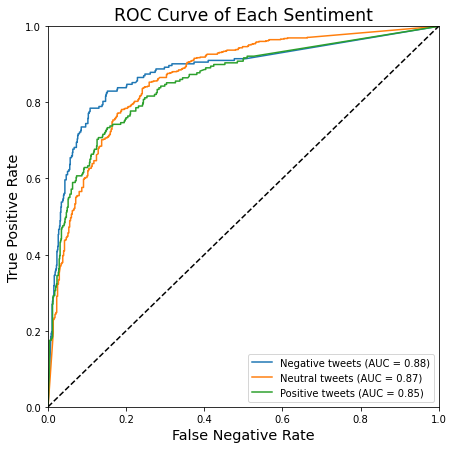

In [0]:
fig = model.plot_roc(X_test, y_test)
fig.savefig('roc.png')

Mean aggregate score error: 0.00407


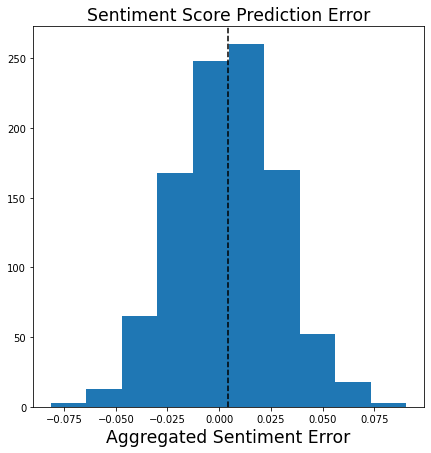

In [0]:
fig = model.agg_sent_hist(X_test, y_test)
print('Mean aggregate score error: {0:.5f}'.format(model.agg_me))
fig.savefig('agg_error_hist.png')

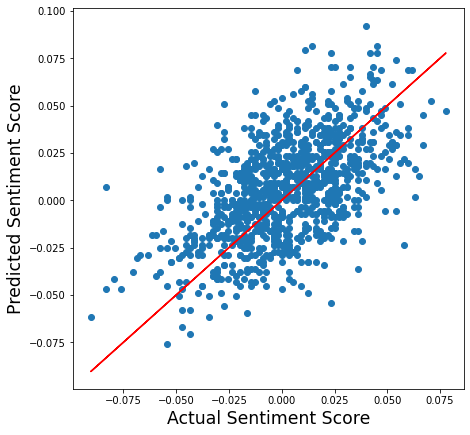

In [0]:
fig = model.agg_sent_plot(X_test, y_test)
fig.savefig('agg_error_scatter.png')

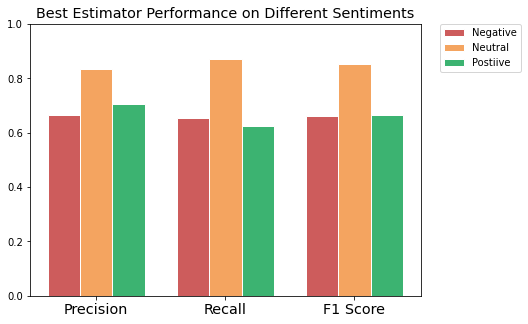

In [0]:
result_dict = model.sentiment_performance(X_test_full, y_test_full)

In [0]:
print('\033[1m\tClassification report on the Original Test Set\033[0m')
model.classification_report(X_test_full, y_test_full)

#print('\n\n\033[1m\tClassification report on the Balanced Test Set\033[0m')
#model.classification_report(X_test_bal, y_test_bal);

	Classification report on the Original Test Set
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       104
           2       0.83      0.87      0.85       334
           4       0.71      0.63      0.66       115

    accuracy                           0.78       553
   macro avg       0.74      0.72      0.73       553
weighted avg       0.78      0.78      0.78       553



**Results on full (unbalanced) validation set**

| | precision   | recall  |f1-score   |support|
|---|-----|-----|-----|----|
|0  |0.67 |0.65 |0.66 |104 |
|2  |0.83 |0.87 |0.85 |334 |
|4  |0.71 |0.63 |0.66 |115 |
| | | | | |
|accuracy  |||0.78 |553 |
|macro avg   |0.74 |0.72 | 0.73 |553|
|weighted avg|0.78 |0.78 | 0.78 |553|



## Compare the different estimators' performance

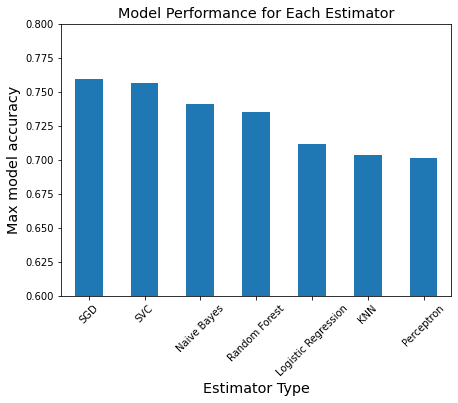

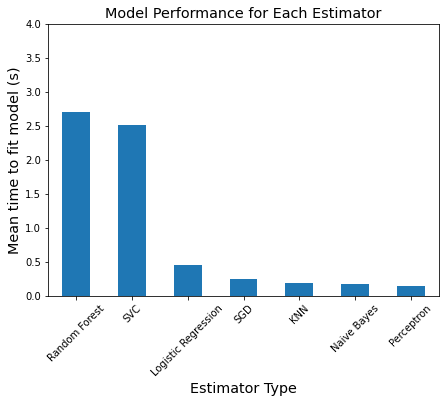

In [0]:
fig = model.estimator_performance('score', ylim=(0.6, 0.8))
fig.savefig('estimator_performance.png')

fig = model.estimator_performance('computing_time', ylim=(0, 4));
fig.savefig('estimator_time.png')

In [0]:
model.results.loc["Naive Bayes", "computing_time"] / model.results.loc["SGD", "computing_time"] 

0.8001837440331866

In [0]:
model.results

,score,ngram_range,tfidf__norm,computing_time,estimator_obj
Estimator,,,,,
SVC,0.756851,"(1, 2)",l2,2.610718,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
Naive Bayes,0.741470,"(1, 2)",l1,0.260630,"MultinomialNB(alpha=1.0, class_prior=None, fit..."
SGD,0.759862,"(1, 2)",l2,0.325713,"SGDClassifier(alpha=0.0001, average=False, cla..."
KNN,0.704060,"(1, 2)",l2,0.252074,"KNeighborsClassifier(algorithm='auto', leaf_si..."
Random Forest,0.735143,"(1, 1)",l2,3.627667,"RandomForestClassifier(bootstrap=True, ccp_alp..."
Perceptron,0.701358,"(1, 1)",l2,0.179613,"Perceptron(alpha=0.0001, class_weight=None, ea..."
Logistic Regression,0.711621,"(1, 1)",l2,0.578500,"LogisticRegression(C=1.0, class_weight=None, d..."


## Using the model to predict sentiment

In [0]:
model.grid.predict_proba(['I love the world'])

array([[0., 0., 1.]])

In [0]:
model.grid.predict_proba(['I am indifferent about the world'])

array([[0.16686553, 0.81078681, 0.02234766]])

In [0]:
model.grid.predict_proba(['I hate the world'])

array([[1., 0., 0.]])

## Create a Word Cloud of the Tweets

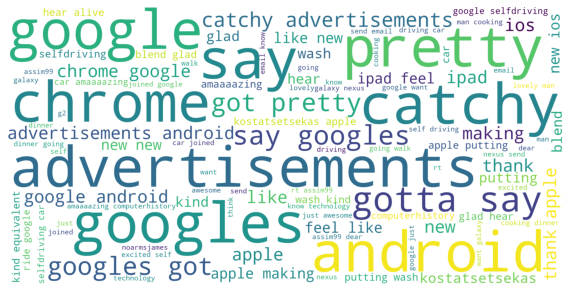

In [0]:
fig = model.word_cloud(X_train, y_train, 'positive')
fig.savefig('wc_train.png')

In [0]:
# Get image to use as mask for word cloud
url = 'https://github.com/DesiPilla/twitter-sentiment-analysis/blob/master/pictures/twitter_mask.png?raw=true'
twitter_mask = io.imread(url)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


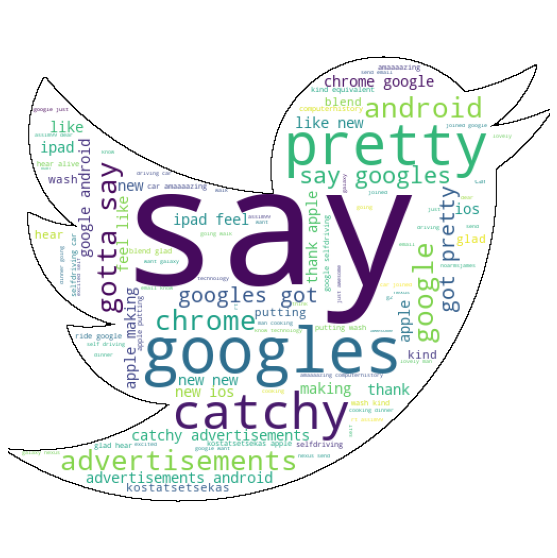

In [0]:
fig = model.word_cloud(X_train, y_train, 'positive', mask=twitter_mask)
fig.savefig('wc_train_pos.png')

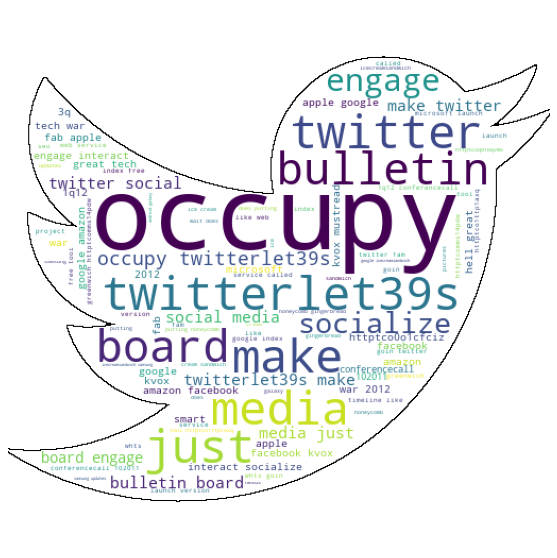

In [0]:
fig = model.word_cloud(X_train, y_train, 'neutral', mask=twitter_mask)
fig.savefig('wc_train_neu.png')

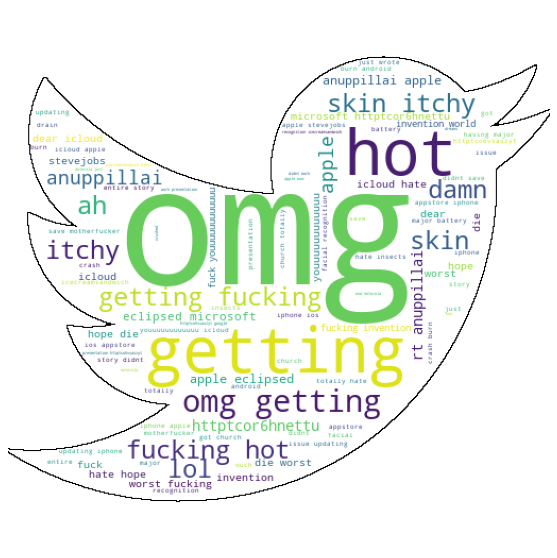

In [0]:
fig = model.word_cloud(X_train, y_train, 'negative', mask=twitter_mask)
fig.savefig('wc_train_neg.png')

# Get Test Set

Now that we have a workable model, let us scrape new, unlabeled tweets from Twitter and glean some aggregated sentiment information about various topics.

First, we will use the Twitter Developers login credentials to authenticate this program. This will allow us to fetch tweets using Twitter's API.

In [13]:
# Developer keys
consumer_key = 'WKZJjQRJBJE6ZXAy8tiBotVV0'
consumer_key_secret = 'dcy3B146XiVTYzcgYO3kqjMS3xiVfqYdUNmRAGftThsiwek36S'

# Secret token (not used anywhere)
access_token_key = '2954379412-yKnvAzEL0KTQUxZPMHQHgwTC7WNbPB7w4AOMrPO'
access_token_key_secret = '9dwQjP3WqnvIclgcnilIqTz27vdRPQgSPfOKKCA7Y4mot'

# Initialize api instance
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token_key, access_token_key_secret)
twitter_api = tweepy.API(auth)
print('Authorization successful:', twitter_api != None)

Authorization successful: True


Next, we will create a function that will gather tweets relating to a specific keyword. The function will take a keyword and the number of tweets to fetch as inputs. We will use this function later to build test sets.

In [0]:
def getTweets(search_term, num_tweets = 10000, rts=False, date=None):
    if not rts:
        search_term += '-filter:retweets'       # Exclude retweets from search
    if date != None:                            # Get tweets at or before a certain date
        fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en', until=date)
        if not fetched_tweets:                  # If certain date was more than a week ago
            fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en')
    else:                                       # Get most recent tweets
        fetched_tweets = twitter_api.search(q=search_term, count=num_tweets, lang='en')
    print("Fetched {0} tweets about {1}".format(num_tweets, search_term))
    return [status.text for status in fetched_tweets]

Let's test this function to see the 10,000 most recent tweets pertaining to the search term `coronavirus`.

In [0]:
# Make query
search_term = 'coronavirus'
num_tweets = 10000

testTweets = getTweets(search_term, num_tweets)
for tweet in testTweets[:5]:
    print('\n', tweet)

Fetched 10000 tweets about coronavirus-filter:retweets

 NEW: 17 Labour MPs – including former leader Jeremy Corbyn – have described the Prime Minister's coronavirus statem… https://t.co/jzzO7SXZLr

 Via @ggwash | 3 graphs and 2 maps about jobs and teleworking during the coronavirus  https://t.co/1wM0laAM4c

 Coronavirus: Covid-19 cases spike as India prepares to exit lockdown https://t.co/mB0Kcri5xT

 Bill gates is funding a vaccine for the Coronavirus that “marks” you once you get it. 
Did you guys also know he ha… https://t.co/uWsJIRwP5h

 waiting for my coronavirus test results is somehow less stressful than waiting for my 202 grade


In [0]:
for tweet in testTweets[:5]:
    print(model.grid.predict_proba([tweet]))

model.predict_agg(testTweets, verbose=True);

[[0.         0.87518854 0.12481146]]
[[0. 1. 0.]]
[[0.0463416  0.86901241 0.08464598]]
[[0.25192696 0.40547494 0.3425981 ]]
[[0.09086834 0.90913166 0.        ]]

(scale from -1 to 1) Aggregated sentiment score: -0.01 ± 0.05



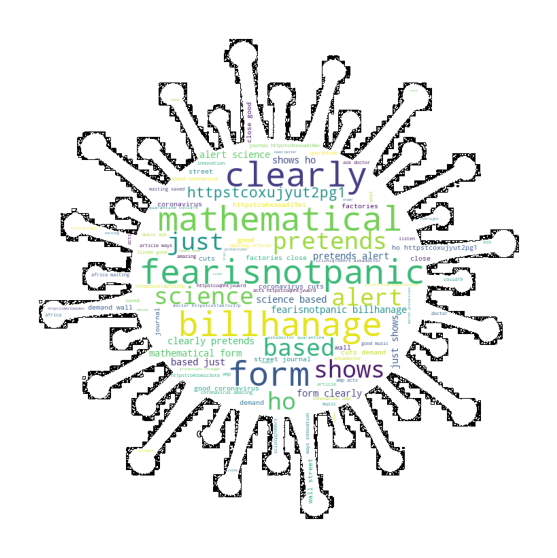

In [0]:
url = 'https://github.com/DesiPilla/twitter-sentiment-analysis/blob/master/pictures/virus_mask.jpg?raw=True'
virus_mask = io.imread(url)

fig = model.word_cloud(testTweets, sentiment='positive', mask=virus_mask)
fig.savefig('wc_corona_pos.png')

# Get sentiment score for any keyword seamlessly

Fetched 10000 tweets about love-filter:retweets

(scale from -1 to 1) Aggregated sentiment score: 0.86 ± 0.05



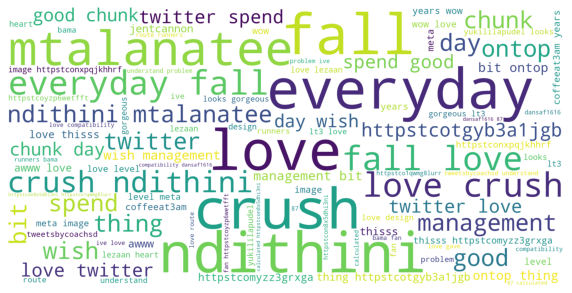

In [0]:
tweets = getTweets('love', 10000)
model.predict_agg(tweets, verbose=True)
model.word_cloud(tweets, sentiment='positive');

In [22]:
tweets = getTweets('bitcoin', 50000, '05-011-2020')
model.predict_agg(tweets, verbose=True);

Fetched 50000 tweets about bitcoin

(scale from -1 to 1) Aggregated sentiment score: -0.08 ± 0.05



In [35]:
n = 50000

tweets = getTweets('Donald Trump', num_tweets=n)
model.predict_agg(tweets, verbose=True)
tweets = getTweets('Donald Trump', num_tweets=n, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Joe Biden', num_tweets=n)
model.predict_agg(tweets, verbose=True)
tweets = getTweets('Joe Biden', num_tweets=n, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Nancy Pelosi', num_tweets=n)
model.predict_agg(tweets, verbose=True)
tweets = getTweets('Nancy Pelosi', num_tweets=n, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Mitch McConnell', num_tweets=n)
model.predict_agg(tweets, verbose=True)
tweets = getTweets('Mitch McConnell', num_tweets=n, rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 50000 tweets about Donald Trump-filter:retweets

(scale from -1 to 1) Aggregated sentiment score: 0.01 ± 0.05

Fetched 50000 tweets about Donald Trump

(scale from -1 to 1) Aggregated sentiment score: 0.05 ± 0.05



Fetched 50000 tweets about Joe Biden-filter:retweets

(scale from -1 to 1) Aggregated sentiment score: -0.08 ± 0.05

Fetched 50000 tweets about Joe Biden

(scale from -1 to 1) Aggregated sentiment score: 0.13 ± 0.05



Fetched 50000 tweets about Nancy Pelosi-filter:retweets

(scale from -1 to 1) Aggregated sentiment score: -0.46 ± 0.05

Fetched 50000 tweets about Nancy Pelosi

(scale from -1 to 1) Aggregated sentiment score: -0.47 ± 0.05



Fetched 50000 tweets about Mitch McConnell-filter:retweets

(scale from -1 to 1) Aggregated sentiment score: -0.04 ± 0.05

Fetched 50000 tweets about Mitch McConnell

(scale from -1 to 1) Aggregated sentiment score: -0.02 ± 0.05



In [38]:
tweets = getTweets('reopen', 50000, rts=True)
model.predict_agg(tweets, verbose=True,)

print('\n')
tweets = getTweets('economy', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('school', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('summer', 50000, rts=True)
model.predict_agg(tweets, verbose=True);

print('\n')
tweets = getTweets('future', 50000, rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 50000 tweets about reopen

(scale from -1 to 1) Aggregated sentiment score: 0.19 ± 0.05



Fetched 50000 tweets about economy

(scale from -1 to 1) Aggregated sentiment score: 0.18 ± 0.05



Fetched 50000 tweets about school

(scale from -1 to 1) Aggregated sentiment score: 0.24 ± 0.05



Fetched 50000 tweets about summer

(scale from -1 to 1) Aggregated sentiment score: -0.16 ± 0.05



Fetched 50000 tweets about future

(scale from -1 to 1) Aggregated sentiment score: 0.06 ± 0.05



In [39]:
tweets = getTweets('Apple', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Google', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Facebook', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Microsoft', 50000, rts=True)
model.predict_agg(tweets, verbose=True);

print('\n')
tweets = getTweets('Tesla', 50000, rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 50000 tweets about Apple

(scale from -1 to 1) Aggregated sentiment score: 0.10 ± 0.05



Fetched 50000 tweets about Google

(scale from -1 to 1) Aggregated sentiment score: 0.06 ± 0.05



Fetched 50000 tweets about Facebook

(scale from -1 to 1) Aggregated sentiment score: 0.07 ± 0.05



Fetched 50000 tweets about Microsoft

(scale from -1 to 1) Aggregated sentiment score: -0.02 ± 0.05



Fetched 50000 tweets about Tesla

(scale from -1 to 1) Aggregated sentiment score: 0.09 ± 0.05



In [43]:
tweets = getTweets('Cryptocurrency', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Bitcoin', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Ethereum', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('Ripple', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('US dollar', 50000, rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 50000 tweets about Cryptocurrency

(scale from -1 to 1) Aggregated sentiment score: 0.20 ± 0.05



Fetched 50000 tweets about Bitcoin

(scale from -1 to 1) Aggregated sentiment score: 0.11 ± 0.05



Fetched 50000 tweets about Ethereum

(scale from -1 to 1) Aggregated sentiment score: -0.01 ± 0.05



Fetched 50000 tweets about Ripple

(scale from -1 to 1) Aggregated sentiment score: 0.18 ± 0.05



Fetched 50000 tweets about US dollar

(scale from -1 to 1) Aggregated sentiment score: 0.05 ± 0.05



In [44]:
tweets = getTweets('blue', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('red', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('green', 50000, rts=True)
model.predict_agg(tweets, verbose=True)

print('\n')
tweets = getTweets('yellow', 50000, rts=True)
model.predict_agg(tweets, verbose=True);

Fetched 50000 tweets about blue

(scale from -1 to 1) Aggregated sentiment score: -0.15 ± 0.05



Fetched 50000 tweets about red

(scale from -1 to 1) Aggregated sentiment score: 0.04 ± 0.05



Fetched 50000 tweets about green

(scale from -1 to 1) Aggregated sentiment score: -0.04 ± 0.05



Fetched 50000 tweets about yellow

(scale from -1 to 1) Aggregated sentiment score: -0.44 ± 0.05



# (in testing. not ready to be added yet)

## Spellcheck

In [0]:
!pip install autocorrect

     |████████████████████████████████| 1.8MB 2.8MB/s 
  Created wheel for autocorrect: filename=autocorrect-1.1.0-cp36-none-any.whl size=1810772 sha256=66cd76a902f81430da5aee25848035136b2f5606bf7ca4d9e62aae13cfbb2d9e
  Stored in directory: /root/.cache/pip/wheels/78/7f/b1/527522820ae623df6a2dbe14f778d23adaea4bebe43f7ebcfe
Successfully built autocorrect


In [0]:
from autocorrect import Speller

In [0]:
spell = Speller(lang='en')
spell('trmp'), spell('hello')

('trap', 'hello')

In [0]:
!pip install symspellpy

     |████████████████████████████████| 2.6MB 2.8MB/s 


In [0]:
from symspellpy import SymSpell, Verbosity
import pkg_resources

In [0]:
sym = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [0]:
error_term = 'hellooo'
sym.lookup(error_term, Verbosity.CLOSEST, include_unknown=True)[0].term

'hello'

In [0]:
nltk.word_tokenize('hello'), nltk.word_tokenize('hellooo')

(['hello'], ['hellooo'])

## Emoji

In [0]:
!pip install emoji

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=b4155e7dc13c55f234ed89351ac838dbd02aeceeb890fda7366f1e95844eeb92
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import emoji

In [0]:
print(emoji.emojize('Python is :thumbs_up:'))

Python is 👍


In [0]:
def getTokens(text):
    stopWords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    text = text.lower()                                                 # Convert text to lower-case
    tokens = nltk.word_tokenize(text)                                   # Tokenize the text
    terms = [word for word in tokens if word not in stopWords]          # Remove tokens that are not stop words
    
    return terms

In [0]:
def getTokens(text):

    stopWords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

    text = text.translate(str.maketrans('', '', string.punctuation))    # Remove punctuation
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)     # Remove URLs
    text = re.sub('@[^\s]+', 'AT_USER', text)                           # Remove usernames
    text = text.lower()                                                 # Convert text to lower-case
    tokens = nltk.word_tokenize(text)                                   # Tokenize the text
    terms = [word for word in tokens if (word not in stopWords and word.isalpha())]# Remove tokens that are not alphabetic or stop words
    
    return terms

In [0]:
em = emoji.emojize(':thumbs_up:')
sent = 'Python is 😀 and \ud83d but not 6'
getTokens(sent), TwitterSentimentModel.getTokens(sent)

(['python', '😀', '\ud83d', '6'], ['python'])

In [0]:
sent.translate(str.maketrans('', '', string.punctuation))

'Python is 😀 and \ud83d but not 6'

# References

[SymSpell](https://towardsdatascience.com/essential-text-correction-process-for-nlp-tasks-f731a025fcc3)

[Big main one](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)

[Search tweets](https://blog.goodaudience.com/using-the-twitter-api-with-python-c6e8da96d273)

[analysis.sentiment.polarity](https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/)

[Textblob documentation](https://textblob.readthedocs.io/en/dev/api_reference.html)

[datasets (categories)](https://lionbridge.ai/datasets/top-20-twitter-datasets-for-natural-language-processing-and-machine-learning/)

[new train data1](https://github.com/TharinduMunasinge/Twitter-Sentiment-Analysis/blob/master/DataSet/FinalizedFull.csv)

documentations about [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

stack overflow for [clfswitcher](https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers)

kaggle [article](https://www.kaggle.com/residentmario/using-keras-models-with-scikit-learn-pipelines) about using keras neural nets in an sklearn framework (for Pipeline)

Literature:

 * [https://en.wikipedia.org/wiki/Inter-rater_reliability](https://en.wikipedia.org/wiki/Inter-rater_reliability)
 * [best model not so good](https://en.wikipedia.org/wiki/Inter-rater_reliability)
 * [what a good score it](https://www.quora.com/What-is-the-accepted-accuracy-of-sentiment-analysis)
 * [github repo](https://github.com/ayushoriginal/Sentiment-Analysis-Twitter) with report-style format
